論文  
https://arxiv.org/abs/2112.10752<br>
<br>
GitHub  
https://github.com/CompVis/stable-diffusion<br>
<br>
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/StableDiffusion_img2img_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境セットアップ

## GPU確認

In [ ]:
!nvidia-smi

## GitHubからコード取得

In [ ]:
%cd /content

!git clone https://github.com/huggingface/diffusers.git

!sed -E -i "s/sample\(generator=generator\)/sample\(\)/" /content/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py

## ライブラリのインストール

In [ ]:
%cd /content

!pip install diffusers transformers scipy ftfy

## Access Token取得
[Huggingface](https://huggingface.co/)にSign Up後メール認証<br>
その後、[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)にアクセスし以下に同意<br>
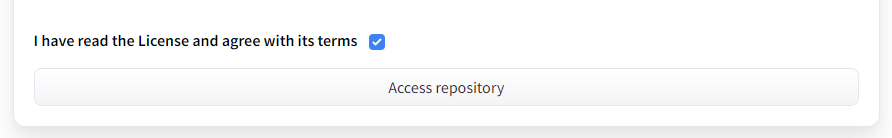
<br><br>
その後、Settings → Access Token
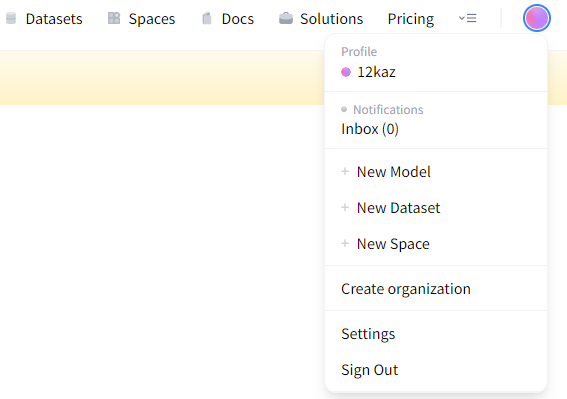


In [ ]:
access_tokens="ここに取得したAccess Tokenを記載" # @param {type:"string"}

## ライブラリのインポート

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import autocast
import numpy as np

%cd /content/diffusers

from diffusers import StableDiffusionImg2ImgPipeline

## preprocess

In [ ]:
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

In [ ]:
%cd /content/diffusers
filename = 'test_01.jpg'

!rm -rf {filename}

!wget -c https://www.pakutaso.com/shared/img/thumb/SAYA160312500I9A3721_TP_V4.jpg \
      -O {filename}

# Image to Image

## load model

In [ ]:
%cd /content/diffusers

device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=access_tokens
).to(device)

## set prompt

In [ ]:
prompt = "detailed CG art, woman at cafe" #@param {type:"string"}

## set image

In [ ]:
%cd /content/diffusers

init_image = Image.open(filename)
if '.png' in filename:
  init_image = init_image.convert('RGB')
resize_image = init_image.resize((768, 512))
input_img = preprocess(resize_image)

plt.imshow(resize_image)
plt.axis('off')
plt.show()

In [ ]:
generator = torch.Generator(device).manual_seed(12)

with autocast("cuda"):
  images = pipe(
      prompt=prompt, init_image=input_img, 
      strength=0.75, guidance_scale=7.5, 
      num_inference_steps=51, generator=generator,)["sample"]

images[0].save("img2img_01.png")

In [ ]:
plt.imshow(plt.imread("img2img_01.png"))

plt.axis('off')
plt.show()